# ImageNet-1K Data Quality and Model Performance

[ImageNet 1K dataset](https://www.image-net.org/index.php) is an established image classification dataset.
Plenty of the off-shief classification models are trained on it.

In this notebook, we demo how much more we can know from such a public dataset and models.

First, let's load necessary packages and setup DuckDB extensions.

In [1]:
import lance
import duckdb
import torchvision
import torch
import pandas as pd
import pyarrow as pa

In [2]:
%load_ext sql
%sql duckdb:///:memory:

{}


In [3]:
!rm -rf /tmp/imagenet*
!curl https://eto-public.s3.amazonaws.com/datasets/imagenet_1k/imagenet_1k.lance.tar.gz --output /tmp/imagenet.lance.tar.gz
!cd /tmp && tar -xvf imagenet.lance.tar.gz

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 2353M  100 2353M    0     0  34.1M      0  0:01:08  0:01:08 --:--:-- 32.6M
imagenet_1k.lance/
imagenet_1k.lance/data/
imagenet_1k.lance/data/5ba7facc-c257-4528-b257-04700234747b_0.lance
imagenet_1k.lance/_versions/
imagenet_1k.lance/_versions/1.manifest
imagenet_1k.lance/_latest.manifest


In [4]:
uri = "/tmp/imagenet_1k.lance"
ds = lance.dataset(uri)

## Take a look at a few rows

In [35]:
%%sql df <<

SELECT * FROM ds LIMIT 10;

Took 0.49007582664489746


,id,image,label,name,split,resnet,vit
0,1,b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x01\x01\x00...,726,"plane, carpenter's plane, woodworking plane",train,"{'label': 726, 'score': 0.6937224268913269, 's...","{'label': 726, 'score': 0.6804487109184265, 's..."
1,2,b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x01\x01\x00...,917,comic book,train,"{'label': 917, 'score': 0.8423280715942383, 's...","{'label': 917, 'score': 0.8432507514953613, 's..."
2,3,b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x01\x01\x00...,13,"junco, snowbird",train,"{'label': 13, 'score': 0.8555507063865662, 'se...","{'label': 13, 'score': 0.837623119354248, 'sec..."
3,4,b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x01\x01\x00...,939,"zucchini, courgette",train,"{'label': 939, 'score': 0.9330726861953735, 's...","{'label': 939, 'score': 0.9347161054611206, 's..."
4,5,b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x01\x01\x00...,6,stingray,train,"{'label': 6, 'score': 0.9341952204704285, 'sec...","{'label': 6, 'score': 0.9426975250244141, 'sec..."
5,6,b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x01\x01\x00...,983,scuba diver,train,"{'label': 983, 'score': 0.7601125836372375, 's...","{'label': 983, 'score': 0.7325905561447144, 's..."
6,7,b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x01\x01\x00...,655,"miniskirt, mini",train,"{'label': 655, 'score': 0.7984981536865234, 's...","{'label': 655, 'score': 0.856082022190094, 'se..."
7,8,b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x01\x01\x00...,579,"grand piano, grand",train,"{'label': 579, 'score': 0.25368696451187134, '...","{'label': 579, 'score': 0.2397327572107315, 's..."
8,9,b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x01\x01\x00...,702,"parallel bars, bars",train,"{'label': 702, 'score': 0.8135064244270325, 's...","{'label': 702, 'score': 0.829046368598938, 'se..."
9,10,b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x01\x01\x00...,845,syringe,train,"{'label': 845, 'score': 0.8958879113197327, 's...","{'label': 845, 'score': 0.9042230248451233, 's..."


<div class="alert alert-block alert-danger"> 
    NEED IMAGE GRID TO WORK FOR EMBEDDED IMAGES
</div>

## We can do some simple summary statistics

Using pandas we can see it has even splits

In [6]:
(ds.scanner(columns=["split"])
 .to_table().to_pandas()
 .split.value_counts())

train         20000
validation    20000
test          20000
Name: split, dtype: int64

We can also query lance datasets using SQL.
Here we check the label distribution

In [7]:
%%sql label_counts <<

SELECT name, count(name) as count
FROM ds
GROUP BY 1
ORDER BY 2 DESC
LIMIT 10

Took 0.03220534324645996


,name,count
0,"tench, Tinca tinca",20031
1,"garter snake, grass snake",58
2,dome,58
3,miniature pinscher,57
4,"toilet tissue, toilet paper, bathroom tissue",56
5,"hoopskirt, crinoline",55
6,flamingo,55
7,collie,55
8,sliding door,54
9,"amphibian, amphibious vehicle",54


<AxesSubplot: xlabel='name'>

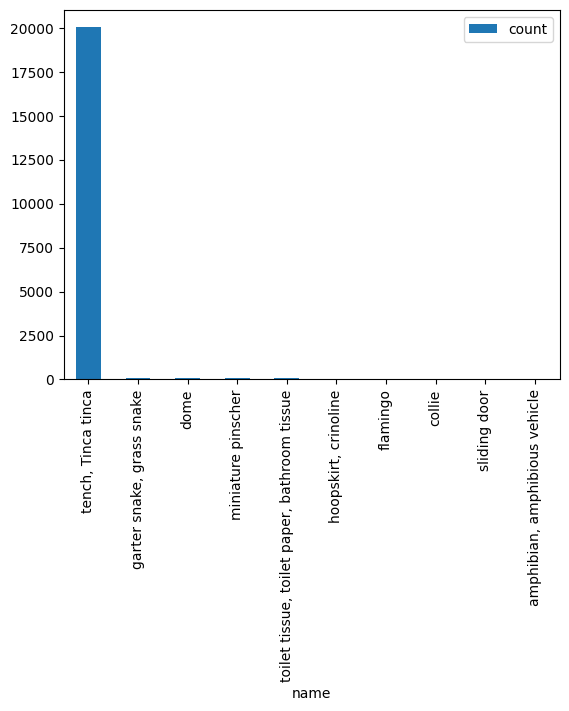

In [8]:
label_counts.set_index('name').plot.bar()

## Use two official pre-trained models ResNet and VisionTransform

We load two pretrained classic CNN and Transformer models to help us understand the dataset better.

* The ResNet model is based on the [Deep Residual Learning for Image Recognition paper](https://arxiv.org/abs/1512.03385)
* The VisionTransformer model is based on the [An Image is Worth 16x16 Words: Transformers for Image Recognition at Scale paper](https://arxiv.org/abs/2010.11929).

Models are moved to the accelerators if available. 
Not only we support CUDA as backend, we support [MPS backend on macOS](https://pytorch.org/docs/stable/notes/mps.html) as well.

In [9]:
from torchvision.models import resnet50, vit_b_16
import torch

# Support CUDA (Linux) or MPS (Mac) backends.
device = torch.device(
    "cuda" if torch.cuda.is_available() else (
        "mps" if torch.backends.mps.is_available() else "cpu")
)

resnet = resnet50(weights="DEFAULT").to(device)
vit = vit_b_16(weights="DEFAULT").to(device)

## Run the inference of these two models

Lance provides native [PyTorch Dataset](https://eto-ai.github.io/lance/api/python/lance.pytorch.html#lance.pytorch.data.Dataset),
which works with PyTorch DataLoader.

We can write a plain PyTorch evaluation loop and persist the predictions back to the dataset for future analysis.



In [10]:
%%time

# TODO: make easy conversion between lance.Dataset and lance.pytorch.Dataset
from lance.pytorch import Dataset
from torch.utils.data import DataLoader

def run_inference(uri: str, model, transform, col_name: str) -> pa.Table:
    dataset = Dataset(
        uri, 
        columns=["id", "image"],
        mode="batch",
        batch_size=128
    )
    data_loader = DataLoader(dataset, batch_size=1, num_workers=4)
    results = []
    with torch.no_grad():
        model.eval()
        for batch in dataset:
            imgs = [transform(img).to(device) for img in batch[1]]
            prediction = resnet(torch.stack(imgs)).squeeze(0).softmax(0)
            topk = torch.topk(prediction, 2)
            for pk, scores, indices in zip(
                batch[0], topk.values.tolist(), topk.indices.tolist()
            ):
                results.append({
                    "id": pk.item(),
                    col_name: {
                        "label": indices[0], 
                        "score": scores[0], 
                        "second_label": indices[1],  # Secondary guess
                        "second_score": scores[1],  # Confidence of the secondary guess.
                    }
                })
    df = pd.DataFrame(data=results)
    df = df.astype({"id": "int32"})
    return pa.Table.from_pandas(df)

resnet_table = run_inference(
    uri, resnet, torchvision.models.ResNet50_Weights.DEFAULT.transforms(), "resnet"
)
vit_table = run_inference(
    uri, vit, torchvision.models.ViT_L_16_Weights.DEFAULT.transforms(), "vit"
)

CPU times: user 37min 41s, sys: 6.38 s, total: 37min 47s
Wall time: 8min 23s


## Add inference results to dataset without copying

Because Lance supports [Schema Evolution](https://en.wikipedia.org/wiki/Schema_evolution), 
it is quite easy to add new columns from the model inference back to the dataset.

In [11]:
ds.schema

id: int32
image: extension<image[binary]<ImageBinaryType>>
label: int16
name: dictionary<values=string, indices=int16, ordered=0>
split: dictionary<values=string, indices=int8, ordered=0>

In [12]:
ds = ds.merge(resnet_table, left_on="id", right_on="id")
ds = ds.merge(vit_table, left_on="id", right_on="id")
ds.schema

id: int32
image: extension<image[binary]<ImageBinaryType>>
label: int16
name: dictionary<values=string, indices=int16, ordered=0>
split: dictionary<values=string, indices=int8, ordered=0>
resnet: struct<label: int64, score: double, second_label: int64, second_score: double>
  child 0, label: int64
  child 1, score: double
  child 2, second_label: int64
  child 3, second_score: double
vit: struct<label: int64, score: double, second_label: int64, second_score: double>
  child 0, label: int64
  child 1, score: double
  child 2, second_label: int64
  child 3, second_score: double

Two columns `resnet` and `vit` are added using a LEFT JOIN algorithm on the "id" column, each of which contains the inference output from the model respectively.

Actually, by doing so, we creates 2 extra versions of Lance dataset. Underneath, Lance only writes the new columns to disk. It will not make extra copy of the existing columns. 

In [13]:
# See multiple versions of the dataset

ds.versions()

[{'version': 1,
  'timestamp': datetime.datetime(2022, 12, 19, 23, 21, 28, tzinfo=datetime.timezone.utc),
  'metadata': {}},
 {'version': 2,
  'timestamp': datetime.datetime(2022, 12, 20, 17, 41, 27, tzinfo=datetime.timezone.utc),
  'metadata': {}},
 {'version': 3,
  'timestamp': datetime.datetime(2022, 12, 20, 17, 41, 27, tzinfo=datetime.timezone.utc),
  'metadata': {}}]

## Model Performance

Using lance and SQL, computing basic ML metrics such as ***precision*** is straightfoward and fast.
SQL support means it's easy to integrate with BI tooling for visualizations

### Model precision

In [14]:
%%sql precision <<

SELECT 
  SUM(CAST(resnet.label = label AS FLOAT)) / COUNT(label) as resnet,
  SUM(CAST(vit.label = label AS FLOAT)) / COUNT(label) as vit
FROM ds 
WHERE split = 'validation'

Took 0.029704570770263672


,resnet,vit
0,0.7862,0.7837


<AxesSubplot: >

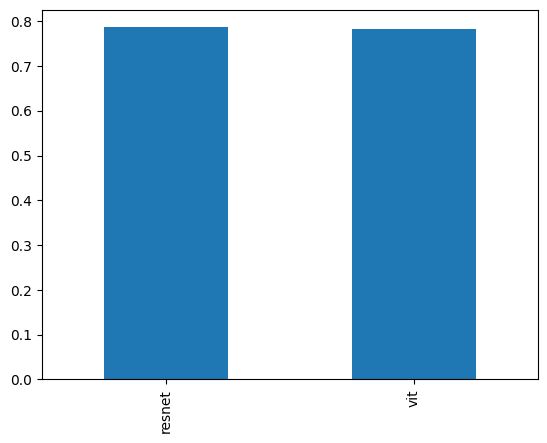

In [15]:
precision.T.rename(columns={0: 'precision'}).squeeze().plot.bar()

### Metrics across arbitrary dimensions

With Lance, it is trivial to slice into each label class to detailed model performance in each class.

For example, we can see that both models consistently perform badly in `maillot` and `sunglass` categories.

In [16]:
%%sql precision_by_class <<

SELECT
  DISTINCT(name) as class,
  SUM(CAST(resnet.label == label AS FLOAT)) / COUNT(label) as resnet,
  SUM(CAST(vit.label == label AS FLOAT)) / COUNT(label) as vit
FROM ds 
WHERE split = 'validation'
GROUP BY name
ORDER BY resnet ASC

Took 0.04000234603881836


,class,resnet,vit
0,maillot,0.055556,0.055556
1,"sunglasses, dark glasses, shades",0.100000,0.100000
2,Appenzeller,0.187500,0.250000
3,monitor,0.200000,0.250000
4,"notebook, notebook computer",0.210526,0.263158
...,...,...,...
995,"yellow lady's slipper, yellow lady-slipper, Cy...",1.000000,1.000000
996,German short-haired pointer,1.000000,1.000000
997,"pug, pug-dog",1.000000,1.000000
998,custard apple,1.000000,1.000000


<AxesSubplot: xlabel='class'>

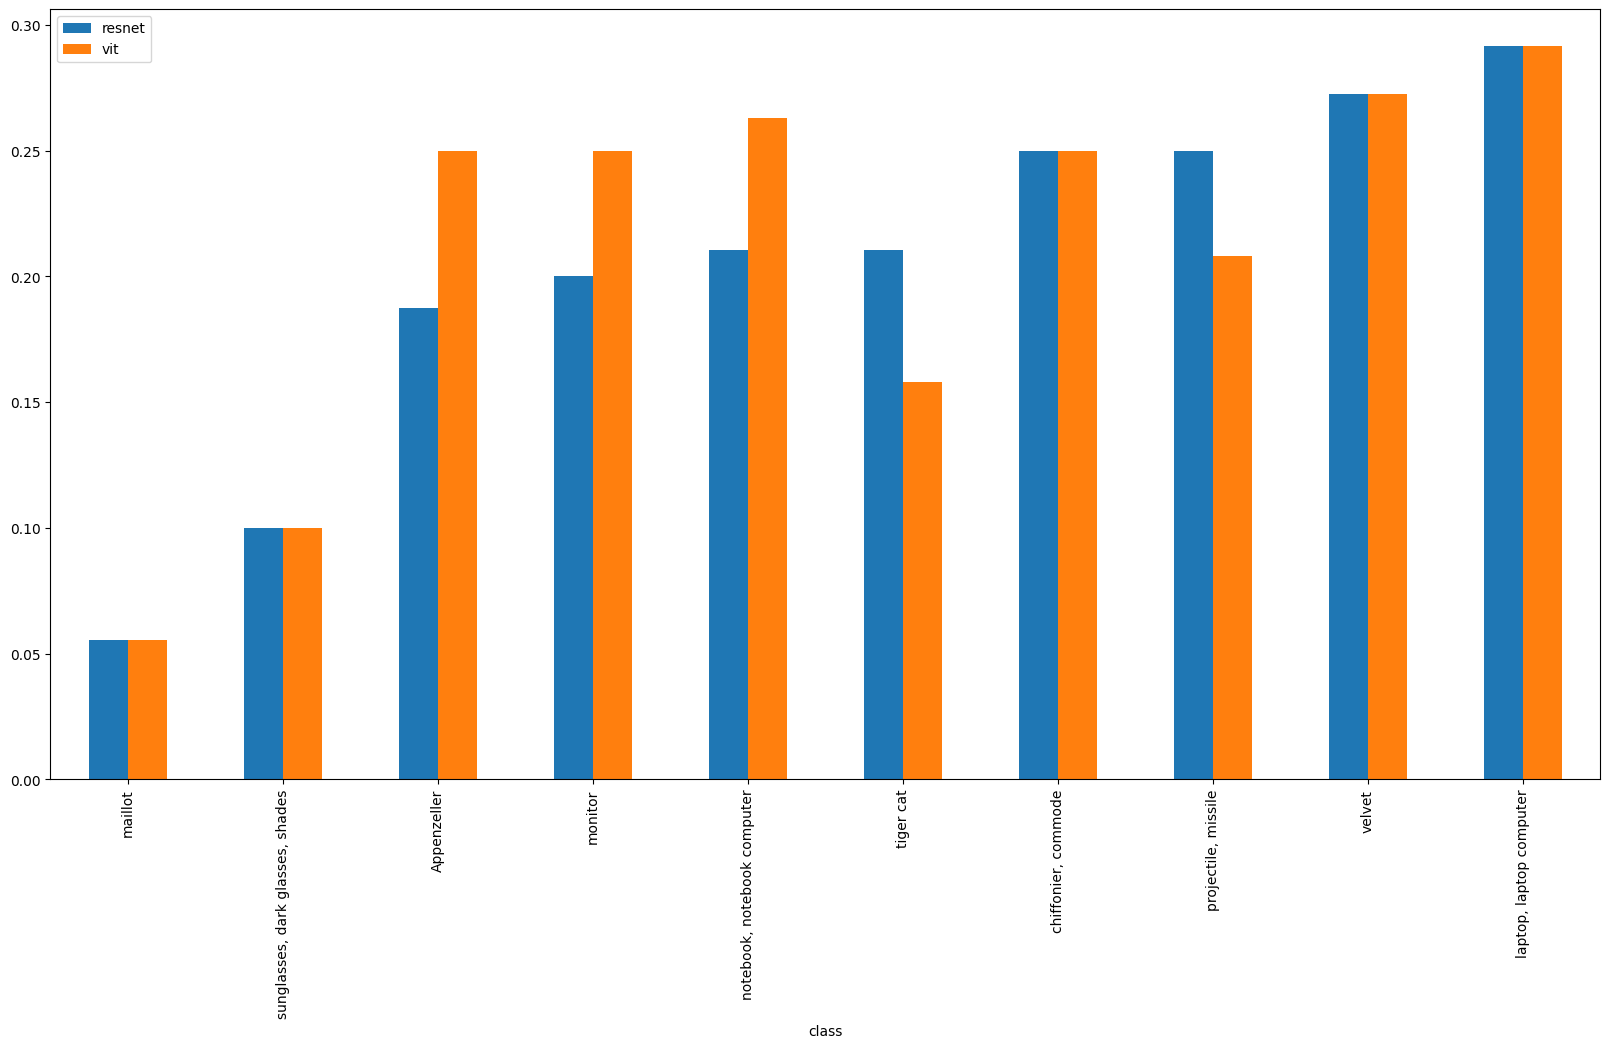

In [17]:
precision_by_class.head(10).set_index('class').plot.bar(figsize=(20,10))

### Confusion matrix

In [18]:
%%sql confusion <<

WITH label_names AS (SELECT DISTINCT label, name FROM ds)

SELECT ds.name as gt, label_names.name as resnet
FROM ds, label_names
WHERE ds.resnet.label=label_names.label

Took 0.16315484046936035


,gt,resnet
0,"plane, carpenter's plane, woodworking plane","plane, carpenter's plane, woodworking plane"
1,comic book,comic book
2,"junco, snowbird","junco, snowbird"
3,stingray,stingray
4,scuba diver,scuba diver
...,...,...
59995,"tench, Tinca tinca","ladybug, ladybeetle, lady beetle, ladybird, la..."
59996,"tench, Tinca tinca","European fire salamander, Salamandra salamandra"
59997,"tench, Tinca tinca",gyromitra
59998,"tench, Tinca tinca",envelope


In [19]:
rs = confusion.reset_index().groupby(['gt', 'resnet']).count().reset_index().rename(columns={'index': 'count'})

In [20]:
rs["pct"] = rs.groupby("gt", group_keys=False)["count"].apply(lambda grp: grp / grp.sum())

<AxesSubplot: xlabel='gt', ylabel='resnet'>

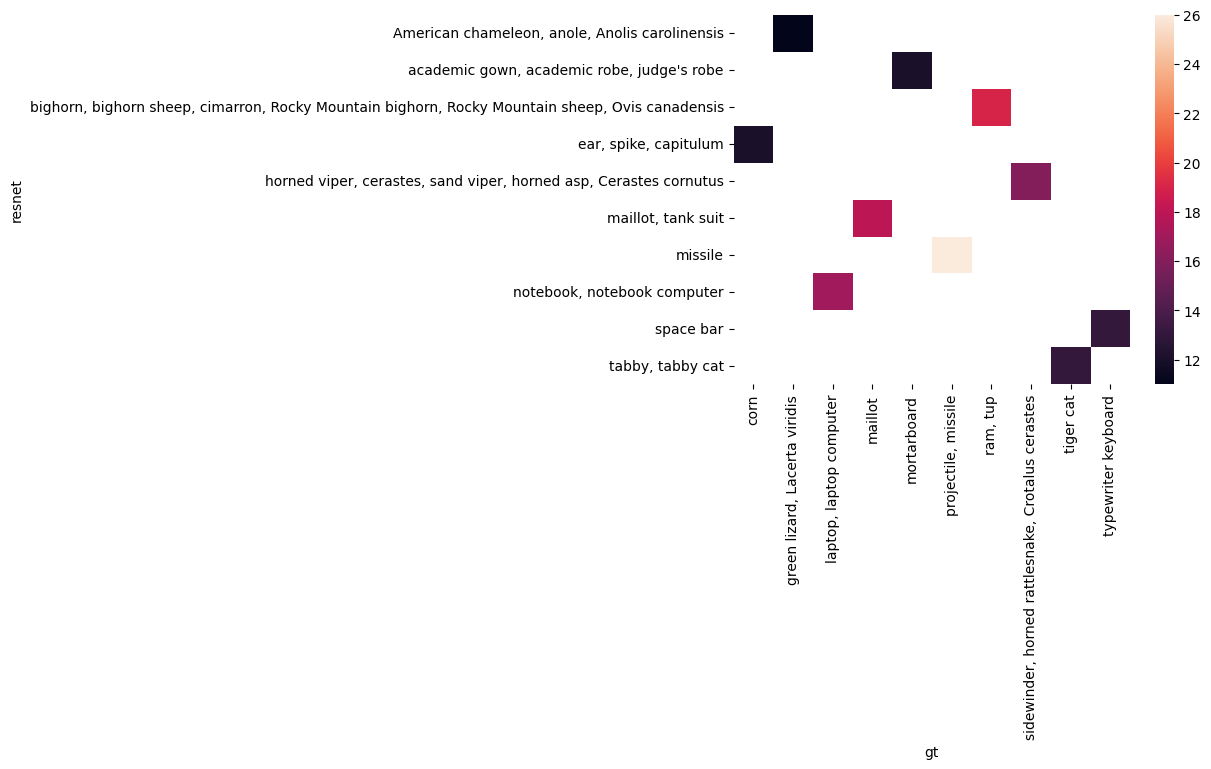

In [22]:
import seaborn as sns

sns.heatmap((rs[rs["gt"] != rs["resnet"]]
             .sort_values("pct", ascending=False).head(10)
             .set_index(["gt", "resnet"])["count"].unstack("gt")))

<div class="alert alert-block alert-info"> 
    💡 INSIGHT: top confused classes are very similar, e.g., "maillot" vs "maillot, tank suit", "laptop" vs "notebook", "missile" vs "projectile, missile"       
</div>

## Automatically Detecting Mislabels

To find potential mislables, we first need to automately establish a baseline of what consider as correct labels.
We establish the baseline via the agreements of the two pre-trained models inference results. That is,
if the two models strongly agree with each other (i.e., same label and confience score is high), but the predict label is not what ground truth describes.

Such logic can be easily expressed via SQL:

In [ ]:
task_type: classification
ground_truth: {label: <>, bounding_box: <>}
predictions: [
    {model_name: <>, label: <>, score: <>, bounding_box: <>}
    ...
]

In [23]:
%%sql

WITH label_names AS (SELECT DISTINCT label, name FROM ds)

SELECT ds.id, ds.name AS ground_truth,
  label_names.name as predict,
  resnet.score as score
FROM ds, label_names 
WHERE
  split != 'test'
  AND ds.label !=  resnet.label 
  AND resnet.label = vit.label
  AND resnet.label = label_names.label
ORDER BY resnet.score DESC
LIMIT 20

Took 0.029463768005371094


,id,ground_truth,predict,score
0,39549,"cellular telephone, cellular phone, cellphone,...","mouse, computer mouse",0.992139
1,20118,holster,bulletproof vest,0.992024
2,13998,beaver,mongoose,0.987393
3,19986,"ice cream, icecream",strawberry,0.984450
4,11193,cloak,sweatshirt,0.983655
5,1444,stretcher,ambulance,0.980116
6,711,"harmonica, mouth organ, harp, mouth harp","ocarina, sweet potato",0.979464
7,2301,table lamp,"lampshade, lamp shade",0.979402
8,23666,goose,"book jacket, dust cover, dust jacket, dust wra...",0.978010
9,19973,"ram, tup","bighorn, bighorn sheep, cimarron, Rocky Mounta...",0.977920


<div class="alert alert-block alert-danger"> 
    NEED IMAGE GRID TO WORK FOR EMBEDDED IMAGES
</div>

While `zucchini` can look similar to `cucumber`, it defintely worths to investigate why the models think `cowboy hat` as `cowboy boot`, and `beaker` as `ping-pong ball`.

We can review the mislabels and send them to labelstudio

<div class="alert alert-block alert-danger"> 
    ADD IN LabelStudio integration here
</div>

Once labels are corrected, we can use Lance's native pytorch integration to retrain the model directly.
For the sake of time here, we'll just show the data loader

In [34]:
dataset = Dataset(
    uri,  # lance uri
    columns=["id", "label", "image"],  # only read certain columns
    batch_size=1
)

for batch in dataset:
    print(batch)
    break

[tensor(1), tensor(726), <PIL.Image.Image image mode=RGB size=817x363 at 0x7FD867FD51E0>]


## Active Learning in Lance

With Lance and DuckDB, it is easy to build active learning loop as well.

One typical approach of Active Learning is finding `Lowest Margin of Confidence`. 

This query finds the examples where a model (*ResNet* in this case) is less confident between the top two candidates.

In [31]:
%%sql

WITH label_names AS (SELECT DISTINCT label, name FROM ds)

SELECT 
    ds.name as gt,
    n1.name as best_guess,
    n2.name as second_guess,
    resnet.score - resnet.second_score AS margin_of_confidence
FROM ds, label_names as n1, label_names as n2
WHERE 
    split != 'test'
    AND n1.label = resnet.label
    AND n2.label = resnet.second_label
ORDER BY margin_of_confidence
LIMIT 20

Took 0.06416940689086914


,gt,best_guess,second_guess,margin_of_confidence
0,power drill,"plane, carpenter's plane, woodworking plane",sewing machine,0.000012
1,shower curtain,four-poster,shower curtain,0.000035
2,maillot,"maillot, tank suit","bikini, two-piece",0.000058
3,coral reef,coral reef,"sea anemone, anemone",0.000097
4,"Airedale, Airedale terrier","borzoi, Russian wolfhound",wire-haired fox terrier,0.000102
5,"bakery, bakeshop, bakehouse","bakery, bakeshop, bakehouse",cup,0.000105
6,"horned viper, cerastes, sand viper, horned asp...","sidewinder, horned rattlesnake, Crotalus cerastes","horned viper, cerastes, sand viper, horned asp...",0.000106
7,missile,missile,"projectile, missile",0.000135
8,wine bottle,beer bottle,wine bottle,0.000143
9,"bolo tie, bolo, bola tie, bola","cash machine, cash dispenser, automated teller...",photocopier,0.000161


Visualizing the results tells us we could improve the model in the following ways:

1. Combine ambiguous categories if they don't matter
2. Adding more distinct and high quality training examples in each of these categories. 
3. Improve feature extraction and the feature residual in the model architecture design.
4. Use multi-models to improve the accuracy in ambiguous case.

## Lance makes it super-simple to create a Data-Driven ML development loop

- Most of the insights here runs in under 100ms, which allows Lance to support a truly interactive ML development loop without external services or heavy infrastructure.

- You don't need to pay LabelBox/ScaleAI for all the data points you don't need to label. If you use LabelStudio you don't need to pay them at all.

- Lance makes it easy to create custom dashboards and views of your data to get to insights quicker